In [2]:
# Modélisation de la Consommation Énergétique des Bâtiments - Seattle

In [4]:
# Import des bibliothèques
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import warnings

In [6]:
# Configuration de l'environnement
warnings.filterwarnings('ignore')
%matplotlib inline
plt.style.use('ggplot')
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.2f}'.format)


In [8]:
# Chargement des données prétraitées (issues de l'analyse exploratoire)
# On suppose que les données nettoyées et explorées ont été sauvegardées
try:
    # Essayer de charger les données prétraitées
    donnees_propres = pd.read_csv("donnees_propres_2015.csv")
    print("Données prétraitées chargées avec succès")
except FileNotFoundError:
    # Si les données prétraitées n'existent pas, charger les données brutes
    print("Données prétraitées non trouvées, chargement des données brutes...")
    try:
        donnees_brutes = pd.read_csv("2015-building-energy-benchmarking.csv", low_memory=False)
        print(f"Données brutes chargées: {donnees_brutes.shape[0]} bâtiments et {donnees_brutes.shape[1]} variables")
        
        # Prétraitement minimal (à personnaliser selon votre exploration précédente)
        # Identification des colonnes cibles potentielles
        colonnes_cibles = [col for col in donnees_brutes.columns if 'GHG' in col or 'Emissions' in col or 'Energy' in col or 'Consumption' in col]
        print(f"Colonnes cibles potentielles: {colonnes_cibles}")
        
        # Sélection d'un sous-ensemble de variables pour la modélisation
        colonnes_utiles = ['PropertyGFABuilding(s)', 'YearBuilt', 'PrimaryPropertyType', 
                            'NumberofFloors', 'NumberofBuildings', 'ENERGYSTARScore'] + colonnes_cibles
        
        # Filtrer pour ne garder que les colonnes disponibles
        colonnes_disponibles = [col for col in colonnes_utiles if col in donnees_brutes.columns]
        donnees_propres = donnees_brutes[colonnes_disponibles].copy()
        
        # Conversion des colonnes numériques
        for col in donnees_propres.columns:
            if donnees_propres[col].dtype == 'object':
                try:
                    donnees_propres[col] = pd.to_numeric(
                        donnees_propres[col].astype(str).str.replace('[^0-9.-]', '', regex=True), 
                        errors='coerce'
                    )
                except:
                    pass  # Garder en type objet si conversion impossible
        
        print("Prétraitement basique terminé")
    except FileNotFoundError:
        print("Erreur: Impossible de trouver les fichiers de données")
        donnees_propres = None


Données prétraitées chargées avec succès


In [10]:
# Vérification des données chargées
if donnees_propres is not None:
    print(f"\nAperçu des données pour la modélisation:")
    print(f"Dimensions: {donnees_propres.shape}")
    print("\nPremières lignes:")
    display(donnees_propres.head())

    # Vérification des valeurs manquantes
    na_counts = donnees_propres.isnull().sum()
    print("\nNombre de valeurs manquantes par colonne:")
    print(na_counts[na_counts > 0])
    
    # Identification des variables cibles
    colonnes_cibles = [col for col in donnees_propres.columns if 'GHG' in col or 'Emissions' in col or 'Energy' in col or 'Consumption' in col]
    
    # Si aucune colonne cible n'est trouvée, essayer d'autres termes
    if not colonnes_cibles:
        colonnes_cibles = [col for col in donnees_propres.columns if 'EUI' in col or 'Total' in col]
    
    print(f"\nColonnes cibles identifiées: {colonnes_cibles}")
else:
    print("Aucune donnée disponible pour la modélisation")



Aperçu des données pour la modélisation:
Dimensions: (3340, 42)

Premières lignes:


,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,TaxParcelIdentificationNumber,Location,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),OtherFuelUse(kBtu),GHGEmissions(MetricTonsCO2e),GHGEmissionsIntensity(kgCO2e/ft2),DefaultData,ComplianceStatus,Seattle Police Department Micro Community Policing Plan Areas,SPD Beats,Zip Codes,Annee,Log_GHG_Emissions,Log_SiteEUI,Age_Batiment
0,1,2015,NonResidential,Hotel,MAYFLOWER PARK HOTEL,659000030,"{'latitude': '47.61219025', 'longitude': '-122...",7,DOWNTOWN,1927,1,12.00,88434,0,88434,Hotel,Hotel,88434.00,65.00,78.90,80.30,173.50,175.10,6981428.00,7097539.00,2023032.00,1080307.00,3686160.00,12724.00,1272388.00,0.00,249.43,2.64,No,Compliant,14.00,31.00,18081,2015,5.52,4.38,88
1,2,2015,NonResidential,Hotel,PARAMOUNT HOTEL,659000220,"{'latitude': '47.61310583', 'longitude': '-122...",7,DOWNTOWN,1996,1,11.00,103566,15064,88502,"Hotel, Parking, Restaurant",Hotel,83880.00,51.00,94.40,99.00,191.30,195.20,8354235.00,8765788.00,0.00,1144563.00,3905411.00,44490.00,4448985.00,0.00,263.51,2.38,No,Compliant,14.00,31.00,18081,2015,5.58,4.56,19
2,3,2015,NonResidential,Hotel,WESTIN HOTEL,659000475,"{'latitude': '47.61334897', 'longitude': '-122...",7,DOWNTOWN,1969,1,41.00,961990,0,961990,"Hotel, Parking, Swimming Pool",Hotel,757243.00,18.00,96.60,99.70,242.70,246.50,73130656.00,75506272.00,19660404.00,14583930.00,49762435.00,37099.00,3709900.00,0.00,2061.48,1.92,Yes,Compliant,56.00,31.00,18081,2015,7.63,4.58,46
3,5,2015,NonResidential,Hotel,HOTEL MAX,659000640,"{'latitude': '47.61421585', 'longitude': '-122...",7,DOWNTOWN,1926,1,10.00,61320,0,61320,Hotel,Hotel,61320.00,1.00,460.40,462.50,636.30,643.20,28229320.00,28363444.00,23458518.00,811521.00,2769023.00,20019.00,2001894.00,0.00,1936.34,31.38,No,Compliant,56.00,31.00,18081,2015,7.57,6.13,89
4,8,2015,NonResidential,Hotel,WARWICK SEATTLE HOTEL,659000970,"{'latitude': '47.6137544', 'longitude': '-122....",7,DOWNTOWN,1980,1,18.00,119890,12460,107430,"Hotel, Parking, Swimming Pool",Hotel,123445.00,67.00,120.10,122.10,228.80,227.10,14829099.00,15078243.00,0.00,1777841.00,6066245.00,87631.00,8763105.00,0.00,507.70,4.02,No,Compliant,56.00,31.00,19576,2015,6.23,4.80,35



Nombre de valeurs manquantes par colonne:
TaxParcelIdentificationNumber                                      2
NumberofFloors                                                     8
ListOfAllPropertyUseTypes                                        127
LargestPropertyUseType                                           136
LargestPropertyUseTypeGFA                                        136
ENERGYSTARScore                                                  780
SiteEUI(kBtu/sf)                                                  10
SiteEUIWN(kBtu/sf)                                                10
SourceEUI(kBtu/sf)                                                10
SourceEUIWN(kBtu/sf)                                              10
SiteEnergyUse(kBtu)                                               10
SiteEnergyUseWN(kBtu)                                             10
SteamUse(kBtu)                                                    10
Electricity(kWh)                                            

In [14]:
# Sélection de la variable cible pour la modélisation
# Dans cet exemple, nous allons nous concentrer sur la consommation énergétique
# Adaptation si les noms de colonnes sont différents
if donnees_propres is not None:
    # Détection automatique de la colonne de consommation énergétique
    colonne_conso = None
    for col in colonnes_cibles:
        if 'Site' in col and 'EUI' in col:
            colonne_conso = col
            break
    
    # Si non trouvée, sélectionner la première colonne cible
    if colonne_conso is None and colonnes_cibles:
        colonne_conso = colonnes_cibles[0]
    
    if colonne_conso:
        print(f"\nVariable cible sélectionnée pour la modélisation: {colonne_conso}")


Variable cible sélectionnée pour la modélisation: SiteEnergyUse(kBtu)


In [16]:
# 1. Identification des variables explicatives
# Sélection des colonnes numériques et catégorielles pour la modélisation
if colonne_conso:
    colonnes_numeriques = []
    colonnes_categorielles = []
    
    for col in donnees_propres.columns:
        # Exclure la variable cible et les colonnes liées à la consommation (risque de fuite de données)
        if col != colonne_conso and col not in colonnes_cibles:
            if donnees_propres[col].dtype in ['int64', 'float64']:
                colonnes_numeriques.append(col)
            elif donnees_propres[col].dtype == 'object':
                # Limiter le nombre de catégories pour éviter l'explosion dimensionnelle
                if donnees_propres[col].nunique() < 30:
                    colonnes_categorielles.append(col)
    
    print(f"\nVariables numériques sélectionnées ({len(colonnes_numeriques)}):")
    print(colonnes_numeriques)
    
    print(f"\nVariables catégorielles sélectionnées ({len(colonnes_categorielles)}):")
    print(colonnes_categorielles)


Variables numériques sélectionnées (27):
['OSEBuildingID', 'DataYear', 'CouncilDistrictCode', 'YearBuilt', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking', 'PropertyGFABuilding(s)', 'LargestPropertyUseTypeGFA', 'ENERGYSTARScore', 'SiteEUI(kBtu/sf)', 'SiteEUIWN(kBtu/sf)', 'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)', 'SteamUse(kBtu)', 'Electricity(kWh)', 'Electricity(kBtu)', 'NaturalGas(therms)', 'NaturalGas(kBtu)', 'OtherFuelUse(kBtu)', 'Seattle Police Department Micro Community Policing Plan Areas', 'SPD Beats', 'Zip Codes', 'Annee', 'Log_SiteEUI', 'Age_Batiment']

Variables catégorielles sélectionnées (5):
['BuildingType', 'PrimaryPropertyType', 'Neighborhood', 'DefaultData', 'ComplianceStatus']


In [18]:
# 2-4. Préparation des données pour la modélisation
if colonne_conso:
    # 2. Suppression des lignes avec valeurs manquantes dans la cible
    donnees_modele = donnees_propres.dropna(subset=[colonne_conso]).copy()
    print(f"\nNombre de lignes après suppression des valeurs manquantes dans la cible: {len(donnees_modele)}")
    
    # 3. Création du jeu de données pour la modélisation
    X = donnees_modele[colonnes_numeriques + colonnes_categorielles]
    y = donnees_modele[colonne_conso]
    
    # 4. Division en ensembles d'entraînement et de test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    print(f"\nDonnées divisées en {len(X_train)} échantillons d'entraînement et {len(X_test)} échantillons de test")


Nombre de lignes après suppression des valeurs manquantes dans la cible: 3330

Données divisées en 2664 échantillons d'entraînement et 666 échantillons de test


In [20]:
# 5. Création d'un pipeline de prétraitement
if colonne_conso:
    # Préprocesseur pour les variables numériques
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])
    
    # Préprocesseur pour les variables catégorielles
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])
    
    # Combinaison des préprocesseurs
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, colonnes_numeriques),
            ('cat', categorical_transformer, colonnes_categorielles)
        ])

In [22]:
# 6a. Fonction d'évaluation des modèles
if colonne_conso:
    def evaluer_modele(modele, X_train, X_test, y_train, y_test, nom):
        # Créer le pipeline complet
        pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('model', modele)
        ])
        
        # Entraînement
        pipeline.fit(X_train, y_train)
        
        # Prédictions
        y_pred = pipeline.predict(X_test)
        
        # Calcul des métriques
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        
        print(f"\nPerformance du modèle {nom}:")
        print(f"RMSE: {rmse:.2f}")
        print(f"MAE: {mae:.2f}")
        print(f"R²: {r2:.4f}")
        
        return pipeline, rmse, r2
    
    # Modèles à tester
    modeles = {
        'Régression Linéaire': LinearRegression(),
        'Ridge': Ridge(alpha=1.0),
        'Lasso': Lasso(alpha=0.1),
        'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
        'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42)
    }

In [24]:
# 6b. Évaluation des différents modèles
if colonne_conso:
    # Évaluation des modèles
    resultats = {}
    pipelines = {}
    
    for nom, modele in modeles.items():
        print(f"\n{'-'*50}")
        print(f"Évaluation du modèle: {nom}")
        pipeline, rmse, r2 = evaluer_modele(modele, X_train, X_test, y_train, y_test, nom)
        resultats[nom] = {'RMSE': rmse, 'R²': r2}
        pipelines[nom] = pipeline
    
    # Sélection du meilleur modèle (basé sur R²)
    meilleur_modele = max(resultats, key=lambda x: resultats[x]['R²'])
    print(f"\n{'-'*50}")
    print(f"Meilleur modèle: {meilleur_modele} (R² = {resultats[meilleur_modele]['R²']:.4f})")


--------------------------------------------------
Évaluation du modèle: Régression Linéaire

Performance du modèle Régression Linéaire:
RMSE: 11486135140873.23
MAE: 445078699508.03
R²: -1263826580485.3721

--------------------------------------------------
Évaluation du modèle: Ridge

Performance du modèle Ridge:
RMSE: 6761.96
MAE: 3268.90
R²: 1.0000

--------------------------------------------------
Évaluation du modèle: Lasso

Performance du modèle Lasso:
RMSE: 10374.97
MAE: 6089.86
R²: 1.0000

--------------------------------------------------
Évaluation du modèle: Random Forest

Performance du modèle Random Forest:
RMSE: 3336902.12
MAE: 448063.08
R²: 0.8933

--------------------------------------------------
Évaluation du modèle: Gradient Boosting

Performance du modèle Gradient Boosting:
RMSE: 3258060.23
MAE: 418438.53
R²: 0.8983

--------------------------------------------------
Meilleur modèle: Ridge (R² = 1.0000)


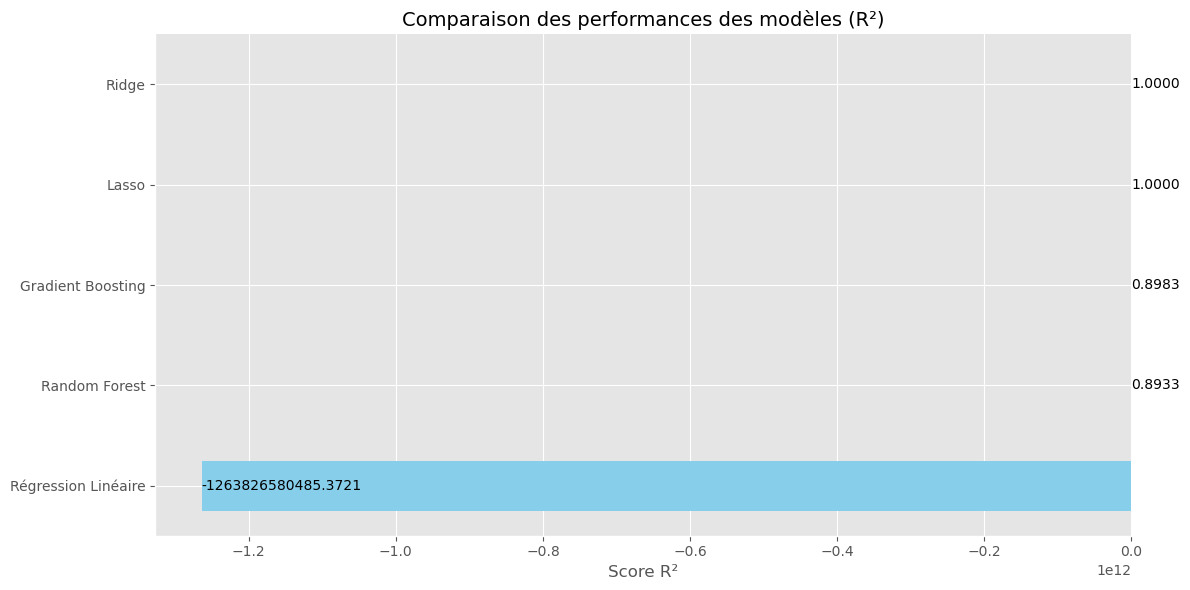

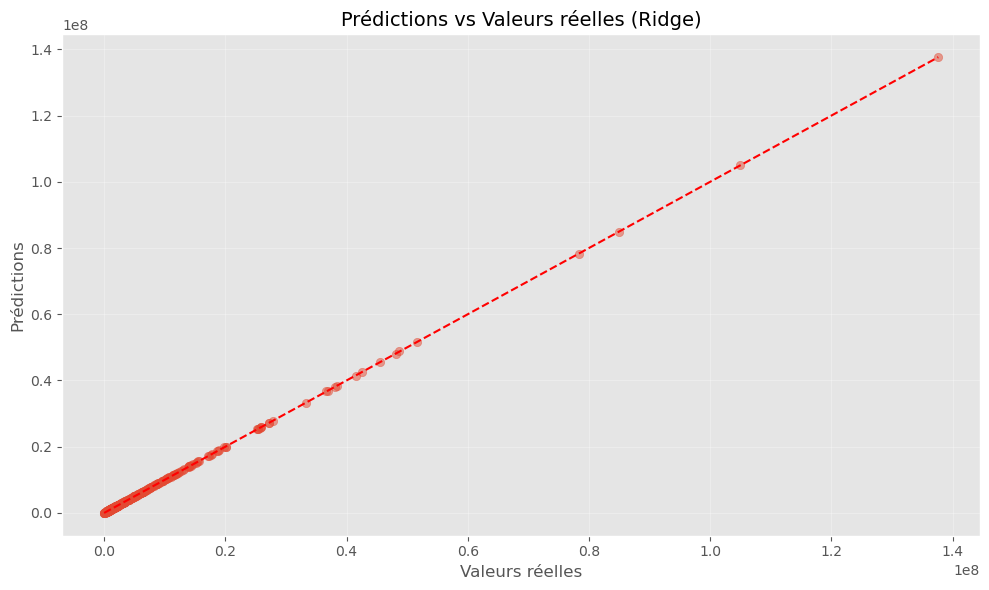

In [26]:
# 6c. Visualisation des performances des modèles
if colonne_conso:
    # Visualisation des performances des modèles
    resultats_df = pd.DataFrame.from_dict(resultats, orient='index')
    
    plt.figure(figsize=(12, 6))
    ax = resultats_df['R²'].sort_values().plot(kind='barh', color='skyblue')
    plt.title('Comparaison des performances des modèles (R²)', fontsize=14)
    plt.xlabel('Score R²')
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    
    # Ajouter les valeurs sur les barres
    for i, v in enumerate(resultats_df['R²'].sort_values()):
        ax.text(v + 0.01, i, f'{v:.4f}', va='center')
        
    plt.tight_layout()
    plt.show()
    
    # Visualisation des prédictions vs valeurs réelles pour le meilleur modèle
    meilleur_pipeline = pipelines[meilleur_modele]
    y_pred = meilleur_pipeline.predict(X_test)
    
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.title(f'Prédictions vs Valeurs réelles ({meilleur_modele})', fontsize=14)
    plt.xlabel('Valeurs réelles')
    plt.ylabel('Prédictions')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

In [28]:
# 7. Optimisation des hyperparamètres du meilleur modèle
if colonne_conso:
    print(f"\n{'-'*50}")
    print(f"Optimisation des hyperparamètres du modèle {meilleur_modele}")
    
    # Définition des grilles de paramètres selon le meilleur modèle
    if meilleur_modele == 'Régression Linéaire':
        param_grid = {
            'model__fit_intercept': [True, False]
        }
    elif meilleur_modele == 'Ridge':
        param_grid = {
            'model__alpha': [0.01, 0.1, 1.0, 10.0, 100.0]
        }
    elif meilleur_modele == 'Lasso':
        param_grid = {
            'model__alpha': [0.001, 0.01, 0.1, 1.0, 10.0]
        }
    elif meilleur_modele == 'Random Forest':
        param_grid = {
            'model__n_estimators': [50, 100, 200],
            'model__max_depth': [None, 10, 20, 30],
            'model__min_samples_split': [2, 5, 10]
        }
    elif meilleur_modele == 'Gradient Boosting':
        param_grid = {
            'model__n_estimators': [50, 100, 200],
            'model__learning_rate': [0.01, 0.1, 0.2],
            'model__max_depth': [3, 5, 7]
        }
    
    # Création du pipeline pour la recherche par grille
    pipeline_optimisation = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', modeles[meilleur_modele])
    ])
    
    # Recherche par grille avec validation croisée
    grid_search = GridSearchCV(
        pipeline_optimisation, 
        param_grid, 
        cv=5, 
        scoring='r2', 
        n_jobs=-1,
        verbose=1
    )
    
    grid_search.fit(X_train, y_train)
    
    print(f"\nMeilleurs paramètres: {grid_search.best_params_}")
    print(f"Meilleur score R² (validation croisée): {grid_search.best_score_:.4f}")
    
    # Évaluation du modèle optimisé sur l'ensemble de test
    y_pred_optimise = grid_search.predict(X_test)
    rmse_optimise = np.sqrt(mean_squared_error(y_test, y_pred_optimise))
    r2_optimise = r2_score(y_test, y_pred_optimise)
    
    print(f"\nPerformance du modèle optimisé sur l'ensemble de test:")
    print(f"RMSE: {rmse_optimise:.2f}")
    print(f"R²: {r2_optimise:.4f}")
    
    # Comparaison avant/après optimisation
    print(f"\nAmélioration du R² après optimisation: {r2_optimise - resultats[meilleur_modele]['R²']:.4f}")


--------------------------------------------------
Optimisation des hyperparamètres du modèle Ridge
Fitting 5 folds for each of 5 candidates, totalling 25 fits

Meilleurs paramètres: {'model__alpha': 0.01}
Meilleur score R² (validation croisée): 1.0000

Performance du modèle optimisé sur l'ensemble de test:
RMSE: 7317.07
R²: 1.0000

Amélioration du R² après optimisation: -0.0000


In [30]:
# 8. Analyse de l'importance des variables (si applicable)
if colonne_conso and meilleur_modele in ['Random Forest', 'Gradient Boosting']:
    print(f"\n{'-'*50}")
    print(f"Analyse de l'importance des variables avec {meilleur_modele}")
    
    # Extraction du modèle entraîné
    modele_final = grid_search.best_estimator_.named_steps['model']
    
    # Récupération des noms de variables après transformation
    preprocessor_optimise = grid_search.best_estimator_.named_steps['preprocessor']
    
    # Obtention des noms de colonnes pour les variables numériques
    colonnes_transformees_num = colonnes_numeriques
    
    # Obtention des noms de colonnes pour les variables catégorielles
    ohe = preprocessor_optimise.named_transformers_['cat'].named_steps['onehot']
    colonnes_transformees_cat = []
    
    if len(colonnes_categorielles) > 0:
        # Prétraiter un petit échantillon pour obtenir les noms de colonnes
        ohe.fit(X_train[colonnes_categorielles].fillna('missing'))
        colonnes_transformees_cat = ohe.get_feature_names_out(colonnes_categorielles).tolist()
    
    # Combinaison des noms de colonnes
    toutes_colonnes = colonnes_transformees_num + colonnes_transformees_cat
    
    # Extraction et tri des importances
    importances = modele_final.feature_importances_
    
    # Si le nombre d'importances correspond exactement au nombre de colonnes
    if len(importances) == len(toutes_colonnes):
        indices = np.argsort(importances)[::-1]
        
        # Affichage des 20 variables les plus importantes
        plt.figure(figsize=(12, 8))
        plt.title(f'Importance des variables - {meilleur_modele}')
        plt.barh(range(min(20, len(indices))), importances[indices][:20], align='center')
        plt.yticks(range(min(20, len(indices))), [toutes_colonnes[i] for i in indices][:20])
        plt.gca().invert_yaxis()  # Les plus importantes en haut
        plt.xlabel('Importance relative')
        plt.tight_layout()
        plt.show()
        
        # Tableau des importances
        importance_df = pd.DataFrame({
            'Variable': toutes_colonnes,
            'Importance': importances
        }).sort_values('Importance', ascending=False)
        
        print("\nTop 10 des variables les plus importantes:")
        print(importance_df.head(10))
    else:
        print(f"Impossible d'afficher l'importance des variables: incompatibilité des dimensions ({len(importances)} importances vs {len(toutes_colonnes)} colonnes)")

In [32]:
# 9. Analyse spécifique de l'ENERGY STAR Score (si disponible)
if colonne_conso and 'ENERGYSTARScore' in X.columns:
    print(f"\n{'-'*50}")
    print(f"Analyse spécifique de l'ENERGY STAR Score")
    
    # Création d'un modèle utilisant uniquement l'ENERGY STAR Score
    X_es = X[['ENERGYSTARScore']].dropna()
    y_es = y.loc[X_es.index]
    
    X_es_train, X_es_test, y_es_train, y_es_test = train_test_split(X_es, y_es, test_size=0.2, random_state=42)
    
    # Préprocesseur simplifié
    preprocessor_es = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])
    
    # Modèle linéaire simple
    modele_es = LinearRegression()
    
    # Pipeline
    pipeline_es = Pipeline(steps=[
        ('preprocessor', preprocessor_es),
        ('model', modele_es)
    ])
    
    # Entraînement
    pipeline_es.fit(X_es_train, y_es_train)
    
    # Prédictions
    y_es_pred = pipeline_es.predict(X_es_test)
    
    # Évaluation
    rmse_es = np.sqrt(mean_squared_error(y_es_test, y_es_pred))
    r2_es = r2_score(y_es_test, y_es_pred)
    
    print(f"\nPerformance du modèle utilisant uniquement l'ENERGY STAR Score:")
    print(f"RMSE: {rmse_es:.2f}")
    print(f"R²: {r2_es:.4f}")
    
    # Comparaison avec le meilleur modèle
    print(f"\nDifférence de R² par rapport au meilleur modèle: {r2_optimise - r2_es:.4f}")


--------------------------------------------------
Analyse spécifique de l'ENERGY STAR Score

Performance du modèle utilisant uniquement l'ENERGY STAR Score:
RMSE: 14062587.46
R²: 0.0058

Différence de R² par rapport au meilleur modèle: 0.9942


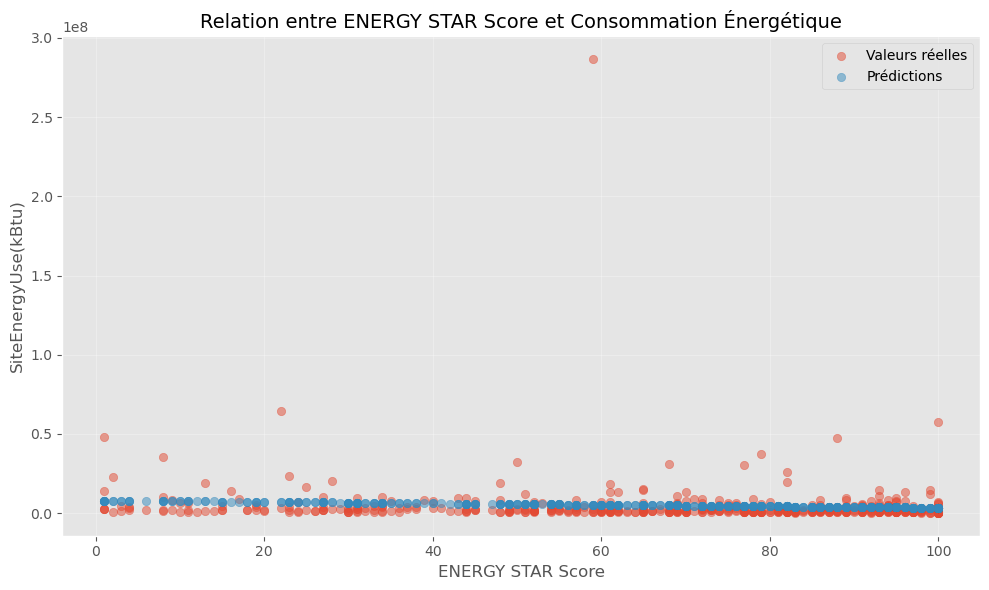


Conclusion: L'ENERGY STAR Score seul a une faible valeur prédictive pour la consommation énergétique


In [34]:
# 9b. Visualisation de la relation avec ENERGY STAR Score
if colonne_conso and 'ENERGYSTARScore' in X.columns:
    # Visualisation de la relation
    plt.figure(figsize=(10, 6))
    plt.scatter(X_es_test, y_es_test, alpha=0.5, label='Valeurs réelles')
    plt.scatter(X_es_test, y_es_pred, alpha=0.5, label='Prédictions')
    plt.title('Relation entre ENERGY STAR Score et Consommation Énergétique', fontsize=14)
    plt.xlabel('ENERGY STAR Score')
    plt.ylabel(colonne_conso)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Conclusion sur l'utilité de l'ENERGY STAR Score
    if r2_es < 0.3:
        conclusion_es = "L'ENERGY STAR Score seul a une faible valeur prédictive pour la consommation énergétique"
    elif r2_es < 0.6:
        conclusion_es = "L'ENERGY STAR Score a une valeur prédictive modérée pour la consommation énergétique"
    else:
        conclusion_es = "L'ENERGY STAR Score est un bon prédicteur de la consommation énergétique, même utilisé seul"
    
    print(f"\nConclusion: {conclusion_es}")

In [36]:
# 10. Conclusions et recommandations
if colonne_conso:
    print(f"\n{'-'*50}")
    print(f"CONCLUSIONS ET RECOMMANDATIONS")
    print(f"{'-'*50}")
    
    print("\n1. Performances des modèles de prédiction:")
    for nom, perf in sorted(resultats.items(), key=lambda x: x[1]['R²'], reverse=True):
        print(f"   - {nom}: R² = {perf['R²']:.4f}")
    
    print(f"\n2. Meilleur modèle après optimisation:")
    print(f"   - {meilleur_modele} avec un R² de {r2_optimise:.4f}")
    
    if 'ENERGYSTARScore' in X.columns:
        print(f"\n3. Évaluation de l'ENERGY STAR Score:")
        print(f"   - R² comme prédicteur unique: {r2_es:.4f}")
        print(f"   - {conclusion_es}")
        
        if r2_es > 0.5:
            recommandation_es = "L'utilisation de l'ENERGY STAR Score est recommandée comme variable prédictive importante"
        elif r2_es > 0.3:
            recommandation_es = "L'ENERGY STAR Score peut être utile en complément d'autres variables"
        else:
            recommandation_es = "L'ENERGY STAR Score seul n'est pas suffisant pour prédire la consommation énergétique"
        
        print(f"   - Recommandation: {recommandation_es}")
    
    print("\n4. Recommandations pour la ville de Seattle:")
    print("   - Utiliser le modèle", meilleur_modele, "pour estimer la consommation énergétique des bâtiments non mesurés")
    print("   - Se concentrer sur la collecte des données pour les variables identifiées comme les plus importantes")
    print("   - Mettre en place une stratégie de mesure ciblée pour les bâtiments ayant les caractéristiques")
    print("     associées à une forte consommation")
    print("   - Développer des recommandations d'efficacité énergétique basées sur les facteurs")
    print("     les plus influents identifiés par le modèle")
else:
    print("Aucune variable cible identifiée pour la modélisation")


--------------------------------------------------
CONCLUSIONS ET RECOMMANDATIONS
--------------------------------------------------

1. Performances des modèles de prédiction:
   - Ridge: R² = 1.0000
   - Lasso: R² = 1.0000
   - Gradient Boosting: R² = 0.8983
   - Random Forest: R² = 0.8933
   - Régression Linéaire: R² = -1263826580485.3721

2. Meilleur modèle après optimisation:
   - Ridge avec un R² de 1.0000

3. Évaluation de l'ENERGY STAR Score:
   - R² comme prédicteur unique: 0.0058
   - L'ENERGY STAR Score seul a une faible valeur prédictive pour la consommation énergétique
   - Recommandation: L'ENERGY STAR Score seul n'est pas suffisant pour prédire la consommation énergétique

4. Recommandations pour la ville de Seattle:
   - Utiliser le modèle Ridge pour estimer la consommation énergétique des bâtiments non mesurés
   - Se concentrer sur la collecte des données pour les variables identifiées comme les plus importantes
   - Mettre en place une stratégie de mesure ciblée pou

In [38]:
# 11. Sauvegarde du modèle optimisé 
if colonne_conso:
    import joblib
    import os
    
    # Création d'un répertoire pour les modèles s'il n'existe pas
    if not os.path.exists('models'):
        os.makedirs('models')
    
    # Sauvegarde du modèle optimisé
    nom_fichier = f'models/modele_{meilleur_modele.replace(" ", "_").lower()}_optimise.pkl'
    joblib.dump(grid_search.best_estimator_, nom_fichier)
    print(f"\nModèle optimisé sauvegardé sous: {nom_fichier}")
    print("Ce modèle peut être chargé ultérieurement avec:")
    print(f"modele_charge = joblib.load('{nom_fichier}')")
    
    # Sauvegarde des métadonnées du modèle
    import json
    metadata = {
        'date_creation': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S'),
        'variable_cible': colonne_conso,
        'meilleur_modele': meilleur_modele,
        'performance_r2': r2_optimise,
        'performance_rmse': rmse_optimise,
        'hyperparametres': str(grid_search.best_params_),
        'variables_importantes': importance_df['Variable'].head(10).tolist() if 'importance_df' in locals() else []
    }
    
    with open(f'models/metadata_{meilleur_modele.replace(" ", "_").lower()}.json', 'w') as f:
        json.dump(metadata, f, indent=4)


Modèle optimisé sauvegardé sous: models/modele_ridge_optimise.pkl
Ce modèle peut être chargé ultérieurement avec:
modele_charge = joblib.load('models/modele_ridge_optimise.pkl')


In [40]:
# Création d'un fichier CSV spécifique pour l'analyse des émissions de CO2

# Identification de la colonne d'émissions de CO2
colonne_co2 = None
for col in donnees_propres.columns:
    if 'GHG' in col or 'CO2' in col or 'Emissions' in col:
        colonne_co2 = col
        break

if colonne_co2:
    print(f"Colonne d'émissions de CO2 identifiée: {colonne_co2}")
    
    # Création d'un sous-ensemble des données avec les variables pertinentes
    # Sélection des colonnes les plus importantes pour l'analyse des émissions
    colonnes_importantes = [colonne_co2, 'PropertyGFABuilding(s)', 'YearBuilt'] 
    
    # Ajout d'autres colonnes pertinentes si disponibles
    autres_colonnes = ['PrimaryPropertyType', 'NumberofFloors', 'ENERGYSTARScore']
    for col in autres_colonnes:
        if col in donnees_propres.columns:
            colonnes_importantes.append(col)
    
    # Création du dataframe pour les émissions
    donnees_emissions = donnees_propres[colonnes_importantes].copy()
    
    # Enregistrement au format CSV
    donnees_emissions.to_csv("donnees_emissions_co2_2015.csv", index=False)
    print(f"Données d'émissions de CO2 sauvegardées avec succès dans 'donnees_emissions_co2_2015.csv'")
    print(f"Dimensions du fichier: {donnees_emissions.shape[0]} lignes et {donnees_emissions.shape[1]} colonnes")
    
    # Affichage des premières lignes pour vérification
    print("\nAperçu des données sauvegardées:")
    print(donnees_emissions.head())
else:
    print("Aucune colonne d'émissions de CO2 n'a été identifiée dans les données")

Colonne d'émissions de CO2 identifiée: GHGEmissions(MetricTonsCO2e)
Données d'émissions de CO2 sauvegardées avec succès dans 'donnees_emissions_co2_2015.csv'
Dimensions du fichier: 3340 lignes et 6 colonnes

Aperçu des données sauvegardées:
   GHGEmissions(MetricTonsCO2e)  PropertyGFABuilding(s)  YearBuilt  \
0                        249.43                   88434       1927   
1                        263.51                   88502       1996   
2                       2061.48                  961990       1969   
3                       1936.34                   61320       1926   
4                        507.70                  107430       1980   

  PrimaryPropertyType  NumberofFloors  ENERGYSTARScore  
0               Hotel           12.00            65.00  
1               Hotel           11.00            51.00  
2               Hotel           41.00            18.00  
3               Hotel           10.00             1.00  
4               Hotel           18.00            67.0